# EEE 443 - Final Project - Image Captioning:

### Group 10:

Ayhan Okuyan, Baris Akcin, Emre Donmez, Hasan Emre Erdemoglu, Ruzgar Eserol, Suleyman Taylan Topaloglu

## LSTM Decoder & Image Captioning: (Part 3/3)

Note that in this section GPU will be utilized as training will be a cumbersome operation for the CPU. Some code is written to identify the GPU. 
    
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [1]:
import tensorflow as tf # tensorflow gpu capabilities available
import os

ROOT_DIR = os.getcwd()
IMG_DIR = os.path.join(ROOT_DIR, 'images')

EXP_DIR = os.path.join(ROOT_DIR, 'exports')
ENC_DIR = os.path.join(EXP_DIR, 'inception_v3_encodings')

CAP_DIR = os.path.join(ROOT_DIR, 'captions')

## Dataset Reading - Extraction & Caption Helper Functions:

In [2]:
import h5py
import numpy as np
from PIL import Image

def eee443_dataset_read(path):
    f = h5py.File(path + '\\eee443_project_dataset_train.h5', 'r')
    train_cap = f.get('train_cap')[()]
    train_imid = f.get('train_imid')[()]
    train_url = None # Already handled
    word_code = f.get('word_code')[()]
    train_ims = None
    
    word_list = list(word_code.dtype.names) # returns the key
    w_all_idx = []
    for word in word_list:
        w_idx = int(word_code[word])
        w_all_idx.append(w_idx)
        
    word_dict = dict(zip(w_all_idx, word_list))
    return train_imid, train_cap, word_dict

def show_image(path, image):
    name = os.path.join(path, image)
    im = Image.open(name)
    display(im)
    return

In [3]:
# Check the text data for images:
# Extracting data from dataset:
def fetch_captions(image_id, train_imid, train_cap, word_dict):
    # Query this on train_imid to extract which indices hold the captions for this image:
    imid = np.array(train_imid)
    indices = np.where(imid == int(image_id))[0] # since everything is string, must be cast to int manually.
                                                 # indices is a tuple of array 
    # Extract the list of integer captions for the given image  
    all_caps = np.array(train_cap)
    count = 1
    caps = []
    for idx in indices:
        cap = all_caps[idx][:]
        caps.append(cap)
        count += 1
    
    # Now do conversion:
    text_cap = []
    count = 0
    for item in caps:
        temp = []
        count += 1
        for word in item:
            temp.append(word_dict[word])
        text_cap.append(temp)

    # Return captions     
    caps = [list(c) for c in caps] # list comprehension to make arrays list
    return indices, text_cap, caps

# Helper function to print captions of an image:
def print_captions(caps, word_dict):
    # Only for displaying
    i = 0
    text_cap = []
    for item in caps:
        i += 1
        temp = []
        print('Caption ', i, ': ',  item)
        for word in item:
            #print(item)
            #print(str(word)  , (word_dict[word]))
            temp.append(word_dict[word])
        text_cap.append(temp)
        # x_NULL_ strings are only ignored, not erased from the captions
        print('Caption ', i, ' textual: ', (' '.join(map(str, temp))).split('x_NULL_')[0])
        print('\n')
    return



In [4]:
# Dataset reading: - Export word_dict too.
train_imid, train_cap, word_dict = eee443_dataset_read(ROOT_DIR) # from previous notebook.

# Print if everything is alright or not.
print('Size of words dictionary: ', len(word_dict.keys()))
print(word_dict[627])

Size of words dictionary:  1004
shop


Indices:  [12376 12425 12565 12689 12809]


Type of captions:  <class 'list'>
Length of captions list:  5
Type of one of the tokenized captions:  <class 'list'>


Caption  1 :  [1, 16, 19, 8, 4, 61, 125, 107, 72, 18, 15, 3, 2, 0, 0, 0, 0]
Caption  1  textual:  x_START_ two people in a food truck one looking at an x_UNK_ x_END_ 


Caption  2 :  [1, 4, 12, 8, 4, 3, 10, 254, 3, 93, 4, 185, 2, 0, 0, 0, 0]
Caption  2  textual:  x_START_ a man in a x_UNK_ and glasses x_UNK_ over a counter x_END_ 


Caption  3 :  [1, 4, 12, 8, 4, 61, 562, 72, 32, 18, 4, 238, 6, 328, 2, 0, 0]
Caption  3  textual:  x_START_ a man in a food cart looking down at a piece of paper x_END_ 


Caption  4 :  [1, 4, 12, 9, 4, 3, 10, 4, 60, 189, 11, 460, 30, 61, 2, 0, 0]
Caption  4  textual:  x_START_ a man with a x_UNK_ and a blue shirt is making some food x_END_ 


Caption  5 :  [1, 4, 28, 507, 143, 7, 185, 6, 4, 61, 125, 2, 0, 0, 0, 0, 0]
Caption  5  textual:  x_START_ a person working behind the counter of a food tru

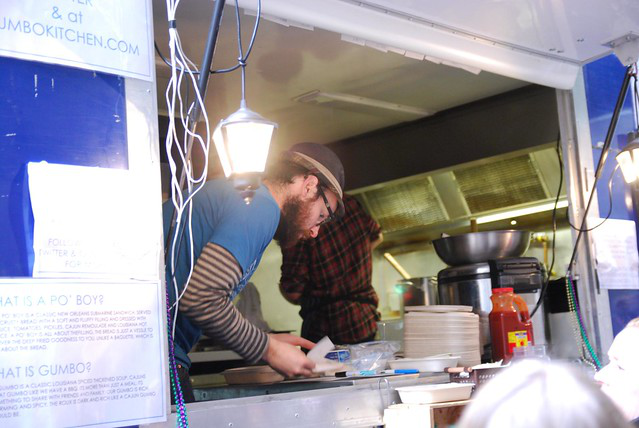

In [5]:
indices, text_cap, caps = fetch_captions(10, train_imid, train_cap, word_dict)

# Validation using image file: '10.jpg'
# Printing the image itself or its encoded output doesn't matter.
print('Indices: ', indices)
print('\n')

print('Type of captions: ', type(caps))
print('Length of captions list: ', len(caps))
print('Type of one of the tokenized captions: ', type(caps[0]))

print('\n')
print_captions(caps, word_dict)

show_image(IMG_DIR, '10')

### Unpack Encoding Data:

In [6]:
sample_list = os.listdir(ENC_DIR)
print(len(sample_list))
print(sample_list[0:10])

valid_image_list = [(int(s.replace('.npy', ''))) for s in sample_list]
print(valid_image_list[0:10])


trial = np.load(os.path.join(ENC_DIR, sample_list[10]))
print('Shape of one embedding:', trial.shape)


73724
['1.npy', '10.npy', '100.npy', '1000.npy', '10000.npy', '10001.npy', '10002.npy', '10003.npy', '10004.npy', '10006.npy']
[1, 10, 100, 1000, 10000, 10001, 10002, 10003, 10004, 10006]
Shape of one embedding: (1, 2048)


In [7]:
#extract captions for existing images
def retreive_capt_id(image_id ,imid_list, cap_list):
    capList = []
    idList = []
    caps = np.where(imid_list == image_id)[0]
    caps = cap_list[caps]
    for cap in caps:
        capList.append(cap)
        idList.append(image_id)
    return capList, idList

def retreive_capt_batch(image_id_list ,imid_list, cap_list):
    idList = []
    captionsList = []
    for image_id in image_id_list:
        caps, ids = retreive_capt_id(image_id,imid_list,cap_list)
        captionsList.extend(caps)
        idList.extend(ids)
    return np.asarray(captionsList), np.asarray(idList)


In [8]:
captions_list, caption_id_list = retreive_capt_batch(valid_image_list,train_imid, train_cap)
print(captionsList.shape)
print(captionIDList.shape)

print(captions_list[0:15,:])
print(caption_id_list[0:15])

if not os.path.exists(CAP_DIR):
    os.mkdir(CAP_DIR)
    
np.save(os.path.join(CAP_DIR, 'captions.npy'), captions_list)
np.save(os.path.join(CAP_DIR, 'captions_id.npy'), caption_id_list)



KeyboardInterrupt: 

## Timeseries Dataset Generation:

(356406, 17) (356406,)
Sample train imid name  17328
Sample train caption  [  1   4 108  26  54 502   3   3   5   4  24   2   0   0   0   0   0]


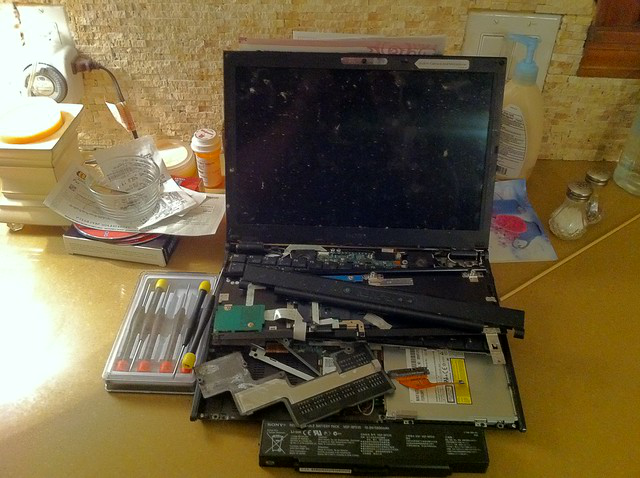

Caption  1 :  [1, 4, 49, 79, 8, 4, 53, 513, 27, 4, 53, 157, 2, 0, 0, 0, 0]
Caption  1  textual:  x_START_ a young boy in a baseball uniform holding a baseball bat x_END_ 


Caption  2 :  [1, 79, 8, 68, 145, 3, 513, 292, 9, 53, 157, 2, 0, 0, 0, 0, 0]
Caption  2  textual:  x_START_ boy in green little x_UNK_ uniform posing with baseball bat x_END_ 


Caption  3 :  [1, 4, 49, 79, 8, 4, 68, 53, 513, 27, 4, 53, 157, 2, 0, 0, 0]
Caption  3  textual:  x_START_ a young boy in a green baseball uniform holding a baseball bat x_END_ 


Caption  4 :  [1, 4, 155, 720, 8, 513, 9, 4, 53, 157, 2, 0, 0, 0, 0, 0, 0]
Caption  4  textual:  x_START_ a child poses in uniform with a baseball bat x_END_ 


Caption  5 :  [1, 4, 37, 79, 720, 80, 4, 101, 8, 4, 53, 513, 2, 0, 0, 0, 0]
Caption  5  textual:  x_START_ a small boy poses xFor a picture in a baseball uniform x_END_ 




Train imids and Captions (320765,) (320765, 17)
Val imids and Captions (35641,) (35641, 17)


In [9]:
### Generate training and test sets:
from sklearn.model_selection import train_test_split

# Load cached caption-id matched lists:
captions_list = np.load(os.path.join(CAP_DIR,'captions.npy'))
caption_id_list = np.load(os.path.join(CAP_DIR,'captions_id.npy'))
print(captions_list.shape, caption_id_list.shape)

#split train and test
img_name_train, img_name_val, cap_train, cap_val = train_test_split(caption_id_list,
                                                                    captions_list,
                                                                    test_size=0.1,
                                                                    random_state=0)

print('Sample train imid name ', img_name_train[5])
print('Sample train caption ', cap_train[5])

show_image(IMG_DIR,  str(img_name_train[5]))
_, _, caps = fetch_captions(img_name_train[20], train_imid, train_cap, word_dict)
print_captions(caps, word_dict)
print('\n')


print('Train imids and Captions', img_name_train.shape, cap_train.shape)
print('Val imids and Captions', img_name_val.shape, cap_val.shape)


In [14]:
#Hyperparameters
BATCH_SIZE = 487
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(word_dict)
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 1

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

def map_func(img_name, cap):
    embed_tensor = np.load(os.path.join(EMBED_DIR, str(img_name)+'.npy'))
    #reshape the 1x8x8x2048 tensor to 64x2048
    n,x,y,z = embed_tensor.shape
    embed_tensor = embed_tensor.reshape((x*y,z))
    return embed_tensor, cap

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
def caption_sequencer(caption):
    sequence, prediction = list(), list()
    
    temp = []
    count = 0
    for i in range(0,max_length-2):
        temp.append(cap_idx[:i+1])
           
        captions.append(temp)
        if cap_idx[i+1] == 0: # np other labeling required
            temp.pop()
            encoding.pop()
            break
        prediction.append(cap_idx[i+1])
    sequence.append(temp)
    
    # For each sequence input must be normalized to max_length pre padding
    for seq in sequence:
        for item in seq: 
            while len(item) < max_length:
                item.insert(0,0)
            item = np.array(item)
            item = np.squeeze(sequence)
    
    encoding = np.array(encoding)
    
    sequence = np.array(sequence)
    sequence = np.squeeze(sequence)
    
    prediction = np.array(prediction)
    return sequence, prediction
    

In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, GRU, add, Bidirectional

def lstm_block(enc_size, vocab_size, max_length, unit_size, drop_rate): # max_length: max length of captions
    # feature extractor model - Already calculated reduce size.
    tin = Input(shape=(enc_size,))
    f1 = Dropout(drop_rate)(tin)
    f2 = Dense(unit_size*2, activation='relu')(f1)
    
    # sequence model - this part is for the captions:
    cin = Input(shape=(max_length,))
    s1 = Embedding(vocab_size, unit_size, mask_zero=True)(cin)
    s2 = Dropout(drop_rate)(s1)
    s3 = Bidirectional(LSTM(unit_size,return_sequences=True))(s2)
    s4 = Bidirectional(LSTM(unit_size))(s3)
    # decoder model
    decoder1 = add([f2, s4])
    decoder2 = Dense(unit_size, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = tf.keras.Model(inputs=[tin,cin], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # summarize model
    #print(model.summary())
    return model

def caption_generator(imgname, enc_dict, word_dict, model, max_length=17):
    START = 1
    END = 2
    
    enc_in = enc_dict[imgname]
    #print(type(enc_in))
    #print(enc_in.shape)
    #print(enc_in)
    
    in_text = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    in_text = np.array(in_text)

    #print(type((in_text)))

    #print(type(in_text))
    #print(len(in_text))
    #print(in_text.shape)
    
    for i in range(max_length-1):
        #print(i)
        pred = model.predict(x=[enc_in.reshape((1,2048)),in_text.reshape((1,17))], verbose=0)
        pred = np.argmax(pred)
        
        in_text = np.delete(in_text, 0)
        in_text = np.append(in_text, pred)
        #print(in_text)
        
        if in_text[-1] == END:
            break
    return in_text
    

In [ ]:
import math
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = lstm_block(2048, 1004, 17, 256, 0.3)
#model.fit([e[:5000], s[:5000]], p[:5000], epochs=10, verbose=1)
model.fit([e, s], p, epochs=20, verbose=1, validation_split=0.9)

In [13]:
print('Train imids and Captions', img_name_train.shape, cap_train.shape)
print('Val imids and Captions', img_name_val.shape, cap_val.shape)

def caption_sequencer(caption, max_length = 17):
    in_seq = []
    for i in range(1,len(caption)):
        seq = caption[:i+1]
        in_seq.append(seq)

    fin_seq = []
    for item in in_seq:
        while len(item) < max_length:
            item = np.append([0],item)
        fin_seq.append(item)
    fin_seq = np.array(fin_seq)
    return fin_seq

print(cap_train[0])
seq = caption_sequencer(cap_train[0])

print(type(seq))
print((seq).shape)
print(seq)

Train imids and Captions (320765,) (320765, 17)
Val imids and Captions (35641,) (35641, 17)
[  1   4 389  51  14   5  33   6   4 753 103   2   0   0   0   0   0]
<class 'numpy.ndarray'>
(16, 17)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   4]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   4 389]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   1   4 389  51]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   4 389  51  14]
 [  0   0   0   0   0   0   0   0   0   0   0   1   4 389  51  14   5]
 [  0   0   0   0   0   0   0   0   0   0   1   4 389  51  14   5  33]
 [  0   0   0   0   0   0   0   0   0   1   4 389  51  14   5  33   6]
 [  0   0   0   0   0   0   0   0   1   4 389  51  14   5  33   6   4]
 [  0   0   0   0   0   0   0   1   4 389  51  14   5  33   6   4 753]
 [  0   0   0   0   0   0   1   4 389  51  14   5  33   6   4 753 103]
 [  0   0   0   0   0   1   4 389  51  14   5  33   6   4 753 103   2]
 [  0   0   0   0   1   

In [38]:
def caption_sequencer(caption, max_length = 17):
    sequence, prediction = list(), list(), list()
    
    temp = []
    count = 0
    for i in range(0,max_length-2):
        temp.append(cap_idx[:i+1])
           
        captions.append(temp)
        if cap_idx[i+1] == 0: # np other labeling required
            temp.pop()
            encoding.pop()
            break
        prediction.append(cap_idx[i+1])
    sequence.append(temp)
    
    # For each sequence input must be normalized to max_length pre padding
    for seq in sequence:
        for item in seq: 
            while len(item) < max_length:
                item.insert(0,0)
            item = np.array(item)
            item = np.squeeze(sequence)
    
    encoding = np.array(encoding)
    
    sequence = np.array(sequence)
    sequence = np.squeeze(sequence)
    
    prediction = np.array(prediction)
    return encoding, sequence, prediction

In [ ]:
from tensorflow.keras.utils import to_categorical

def img_cap_sequence_generator(img_name, h5file, word_dict, enc_dict, max_length = 17):
    enc, seq, prd = list(), list(), list()
    
    _, _, captions = fetch_captions(img_name, h5file, word_dict)
    
    for idx in range(0, len(captions)):
        enc_temp,seq_temp,prd_temp = caption_sequencer(img_name, enc_dict, captions[idx])
        enc.append(enc_temp)
        seq.append(seq_temp)
        prd.append(prd_temp)
        
    return enc, seq, prd

def caption_sequencer(img_name, enc_dict, cap_idx, max_length = 17):
    encoding, sequence, prediction = list(), list(), list()
    
    temp = []
    count = 0
    for i in range(0,max_length-2):
        encoding.append(enc_dict[img_name])
        temp.append(cap_idx[:i+1])
           
        captions.append(temp)
        if cap_idx[i+1] == 0: # np other labeling required
            temp.pop()
            encoding.pop()
            break
        prediction.append(cap_idx[i+1])
    sequence.append(temp)
    
    # For each sequence input must be normalized to max_length pre padding
    for seq in sequence:
        for item in seq: 
            while len(item) < max_length:
                item.insert(0,0)
            item = np.array(item)
            item = np.squeeze(sequence)
    
    encoding = np.array(encoding)
    
    sequence = np.array(sequence)
    sequence = np.squeeze(sequence)
    
    prediction = np.array(prediction)
    return encoding, sequence, prediction
    
def stack_lists(enc,caps,prd):
    return np.vstack(enc), np.vstack(caps), np.hstack(prd)

def list_sequence_gen(ims, f, word_dict, enc_inception_dict, classes=1004):
    e,s,p = list(),list(),list()
    for item in ims:
        enc, seq, prd = img_cap_sequence_generator(item, f, word_dict, enc_inception_dict)
        enc,seq,prd = stack_lists(enc, seq, prd)
        e.append(enc)
        s.append(seq)
        p.append(prd)
    e,s,p = stack_lists(e, s, p)
    p = to_categorical(p, num_classes=classes)
    return e,s,p
        

# TODO HERE

In [ ]:
_, _, captions = fetch_captions('10', f, word_dict)
print('cap ln ', len(captions[0]))
print('cap ', (captions[0]))
print('\n')

enc,caps,preds = caption_sequencer('10', enc_inception_dict, captions[0])

print('enc: ', (enc).shape)
print('caps ', type(caps[0]))
print('caps ', (caps[6]))
print('caps ', (caps).shape)
print('preds: ', (preds))


In [ ]:
enc, seq, prd = img_cap_sequence_generator('10', f, word_dict, enc_inception_dict)

#enc = np.array(enc)
enc,seq,prd = stack_lists(enc, seq, prd)

print(type(enc))
print(len(enc))
print((enc).shape)
#print((enc))
print('\n')

print(type(seq))
print(len(seq))
print((seq).shape)
#print((seq))
print('\n')

print(type(prd))
print(len(prd))
print((prd).shape)
#print((prd))
print('\n')

# Test Case:
print((enc[0]))
print((enc[5]))
print((seq[5]))
print((prd[5]))

## Generate data and construct model:


In [ ]:
from sys import getsizeof

ims = train
print(len(ims))

e,s,p = list_sequence_gen(ims, f, word_dict, enc_inception_dict)

print(e.shape)
print(s.shape)
print(p.shape)


getsizeof(ims)

# TODO FROM HERE

## LSTM Block:


In [ ]:
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, GRU, add, Bidirectional


def lstm_block(enc_size, vocab_size, max_length, unit_size, drop_rate): # max_length: max length of captions
    # feature extractor model - Already calculated reduce size.
    tin = Input(shape=(enc_size,))
    f1 = Dropout(drop_rate)(tin)
    f2 = Dense(unit_size*2, activation='relu')(f1)
    
    # sequence model - this part is for the captions:
    cin = Input(shape=(max_length,))
    s1 = Embedding(vocab_size, unit_size, mask_zero=True)(cin)
    s2 = Dropout(drop_rate)(s1)
    s3 = Bidirectional(LSTM(unit_size,return_sequences=True))(s2)
    s4 = Bidirectional(LSTM(unit_size,return_sequences=True))(s3)
    s5 = Bidirectional(LSTM(unit_size))(s4)
    # decoder model
    decoder1 = add([f2, s5])
    decoder2 = Dense(unit_size, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = tf.keras.Model(inputs=[tin,cin], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # summarize model
    #print(model.summary())
    return model

def caption_generator(imgname, enc_dict, word_dict, model, max_length=17):
    START = 1
    END = 2
    
    enc_in = enc_dict[imgname]
    #print(type(enc_in))
    #print(enc_in.shape)
    #print(enc_in)
    
    in_text = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
    in_text = np.array(in_text)

    #print(type((in_text)))

    #print(type(in_text))
    #print(len(in_text))
    #print(in_text.shape)
    
    for i in range(max_length-1):
        #print(i)
        pred = model.predict(x=[enc_in.reshape((1,2048)),in_text.reshape((1,17))], verbose=0)
        pred = np.argmax(pred)
        
        in_text = np.delete(in_text, 0)
        in_text = np.append(in_text, pred)
        #print(in_text)
        
        if in_text[-1] == END:
            break
    return in_text
    

In [ ]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
model = lstm_block(2048, 1004, 17, 256, 0.5)
model.fit([e, s], p, epochs=5, verbose=1, validation_split=0.2)


In [ ]:
in_text = caption_generator('62850', enc_inception_dict, word_dict,model)
print(in_text)

textual = ''
for word in in_text:
    textual += word_dict[word] + ' '

print(textual)